## Data Download

In [19]:
%pip install SoccerNet opencv-python tqdm matplotlib pandas ultralytics torch torchvision --quiet

Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2


SOCCERNET_DIR = Path(r"C:\Users\USER\Documents\path\to\SoccerNet")      # root download directory
WORK_DIR      = Path(r"C:\Users\USER\Documents\Work")                  # where we'll build YOLO dataset, crops, outputs
WORK_DIR.mkdir(parents=True, exist_ok=True)

print("SOCCERNET_DIR:", SOCCERNET_DIR.resolve())
print("WORK_DIR:", WORK_DIR.resolve())


SOCCERNET_DIR: C:\Users\USER\Documents\path\to\SoccerNet
WORK_DIR: C:\Users\USER\Documents\Work


In [21]:
from SoccerNet.Downloader import SoccerNetDownloader
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory="data/SoccerNetGS")
mySoccerNetDownloader.downloadDataTask(task="gamestate-2024",
                                       split=["train", "valid", "test", "challenge"])

data/SoccerNetGS\gamestate-2024\train.zip already exists
data/SoccerNetGS\gamestate-2024\valid.zip already exists
data/SoccerNetGS\gamestate-2024\test.zip already exists
data/SoccerNetGS\gamestate-2024\challenge.zip already exists


In [22]:
from pathlib import Path

DATA_ROOT = Path("data/SoccerNetGS")          # your LocalDirectory
ZIP_ROOT  = DATA_ROOT / "gamestate-2024"      # where the zips were downloaded

print("DATA_ROOT:", DATA_ROOT.resolve())
print("ZIP_ROOT :", ZIP_ROOT.resolve())
print("Zips found:", list(ZIP_ROOT.glob("*.zip")))

DATA_ROOT: C:\Users\USER\Documents\data\SoccerNetGS
ZIP_ROOT : C:\Users\USER\Documents\data\SoccerNetGS\gamestate-2024
Zips found: [WindowsPath('data/SoccerNetGS/gamestate-2024/challenge.zip'), WindowsPath('data/SoccerNetGS/gamestate-2024/test.zip'), WindowsPath('data/SoccerNetGS/gamestate-2024/train.zip'), WindowsPath('data/SoccerNetGS/gamestate-2024/valid.zip')]


In [23]:
import zipfile

def unzip(zip_path: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(out_dir)
    print(f"✅ Unzipped {zip_path.name} -> {out_dir}")

for split in ["train", "valid", "test", "challenge"]:
    z = ZIP_ROOT / f"{split}.zip"
    out = DATA_ROOT / split
    if not z.exists():
        print("❌ Missing zip:", z)
        continue
    # Skip if already unzipped (basic check)
    if out.exists() and any(out.iterdir()):
        print(f"⏭️  Looks already unzipped: {out}")
    else:
        unzip(z, out)

⏭️  Looks already unzipped: data\SoccerNetGS\train
⏭️  Looks already unzipped: data\SoccerNetGS\valid
⏭️  Looks already unzipped: data\SoccerNetGS\test
⏭️  Looks already unzipped: data\SoccerNetGS\challenge


In [24]:
def count_files(p: Path, pattern="*"):
    return len(list(p.rglob(pattern)))

for split in ["train", "valid", "test", "challenge"]:
    d = DATA_ROOT / split
    if not d.exists():
        continue
    print(f"\n=== {split.upper()} ===")
    print("folders:", len([x for x in d.iterdir() if x.is_dir()]))
    print("json:", count_files(d, "*.json"))
    print("mp4:", count_files(d, "*.mp4"))
    print("jpg:", count_files(d, "*.jpg"))
    print("png:", count_files(d, "*.png"))


=== TRAIN ===
folders: 57
json: 58
mp4: 0
jpg: 42750
png: 0

=== VALID ===
folders: 58
json: 59
mp4: 0
jpg: 43500
png: 0

=== TEST ===
folders: 49
json: 50
mp4: 0
jpg: 36750
png: 0

=== CHALLENGE ===
folders: 36
json: 1
mp4: 0
jpg: 27000
png: 0


In [25]:
import json

label_files = []
for split in ["train", "valid", "test", "challenge"]:
    label_files += list((DATA_ROOT / split).rglob("Labels-GameState.json"))

print("Found Labels-GameState.json:", len(label_files))
for p in label_files[:10]:
    print(" -", p)

if len(label_files) == 0:
    raise RuntimeError("No Labels-GameState.json found. The unzip or folder structure may be different.")

labels_path = label_files[0]
with open(labels_path, "r", encoding="utf-8") as f:
    labels = json.load(f)

print("Opened:", labels_path)
print("Top-level keys:", list(labels.keys())[:20])

# Version check
info = labels.get("info", {})
print("Dataset info:", info)
print("Version:", info.get("version"))


Found Labels-GameState.json: 164
 - data\SoccerNetGS\train\SNGS-060\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-061\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-062\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-063\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-064\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-065\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-066\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-067\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-068\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-069\Labels-GameState.json
Opened: data\SoccerNetGS\train\SNGS-060\Labels-GameState.json
Top-level keys: ['info', 'images', 'annotations', 'categories']
Dataset info: {'version': '1.3', 'game_id': '4', 'id': '060', 'num_tracklets': '26', 'action_position': '895', 'action_class': 'Kick-off', 'visibility': 'visible', 'game_time_start': '1 - 00:00', 'game_time_stop': '1 - 00:30', 'clip_start': '0', 'clip_stop': '30000', 'na

In [26]:
def preview_dict(d, n=20):
    for i, k in enumerate(d.keys()):
        if i >= n:
            break
        print(" -", k)

print("labels keys:")
preview_dict(labels, n=40)

# Try to guess where annotations live:
candidates = ["annotations", "data", "clips", "sequences", "games", "samples"]
for k in candidates:
    if k in labels:
        print("\n✅ Found likely annotation container:", k, "type:", type(labels[k]))


labels keys:
 - info
 - images
 - annotations
 - categories

✅ Found likely annotation container: annotations type: <class 'list'>


Sequence dir: data\SoccerNetGS\train\SNGS-060
Image dir: data\SoccerNetGS\train\SNGS-060\img1
Exists: True
Num frames: 750
First 5: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']


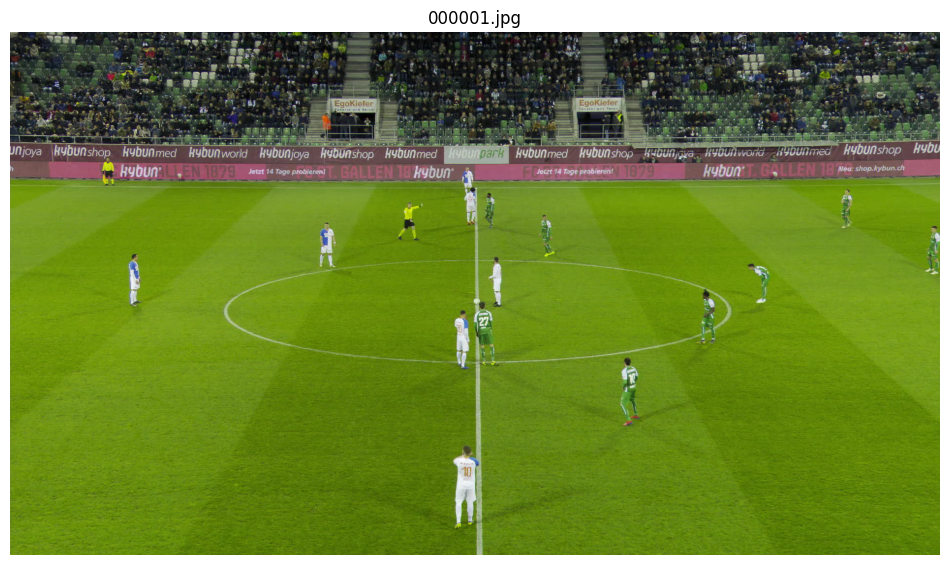

In [27]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

seq_dir = labels_path.parent  # .../train/SNGS-060
img_dir = seq_dir / labels["info"]["im_dir"]  # usually img1
print("Sequence dir:", seq_dir)
print("Image dir:", img_dir)
print("Exists:", img_dir.exists())

# list a few frames
jpgs = sorted(img_dir.glob("*.jpg"))
print("Num frames:", len(jpgs))
print("First 5:", [p.name for p in jpgs[:5]])

# load first frame
if len(jpgs) > 0:
    img_bgr = cv2.imread(str(jpgs[0]))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,7))
    plt.imshow(img_rgb)
    plt.title(jpgs[0].name)
    plt.axis("off")
    plt.show()


In [28]:
import pandas as pd

cats = labels["categories"]
df_cats = pd.DataFrame(cats)
df_cats

,supercategory,id,name,lines
0,object,1,player,NaN
1,object,2,goalkeeper,NaN
2,object,3,referee,NaN
3,object,4,ball,NaN
4,pitch,5,pitch,"[Big rect. left bottom, Big rect. left main, B..."
5,camera,6,camera,NaN
6,object,7,other,NaN


In [29]:
import random
import json

a = random.choice(labels["annotations"])
print("Annotation keys:", list(a.keys()))

# show full annotation (pretty)
print(json.dumps(a, indent=2)[:2000])  # truncate for readability

Annotation keys: ['id', 'image_id', 'track_id', 'supercategory', 'category_id', 'attributes', 'bbox_image', 'bbox_pitch', 'bbox_pitch_raw']
{
  "id": "1060013897",
  "image_id": "1060000701",
  "track_id": 5,
  "supercategory": "object",
  "category_id": 1,
  "attributes": {
    "role": "player",
    "jersey": "75",
    "team": "right"
  },
  "bbox_image": {
    "x": 1668,
    "y": 422,
    "x_center": 1684.0,
    "y_center": 469.5,
    "w": 32,
    "h": 95
  },
  "bbox_pitch": {
    "x_bottom_left": 22.353772492659036,
    "y_bottom_left": 10.56359285984321,
    "x_bottom_right": 23.12663143351588,
    "y_bottom_right": 10.709427961095642,
    "x_bottom_middle": 22.740333821994053,
    "y_bottom_middle": 10.636528991792279
  },
  "bbox_pitch_raw": {
    "x_bottom_left": 22.510643208932272,
    "y_bottom_left": 10.511313468575521,
    "x_bottom_right": 23.127523089826656,
    "y_bottom_right": 10.627124548826657,
    "x_bottom_middle": 22.819157220974198,
    "y_bottom_middle": 10.5692

In [30]:
# COCO bbox is [x, y, w, h] in pixels
im0 = labels["images"][0]
print("Image keys:", im0.keys())
print("Example image entry:", im0)

# find width/height if present
W = im0.get("width", None)
H = im0.get("height", None)
print("W,H:", W, H)

Image keys: dict_keys(['is_labeled', 'image_id', 'file_name', 'height', 'width', 'has_labeled_person', 'has_labeled_pitch', 'has_labeled_camera', 'ignore_regions_y', 'ignore_regions_x'])
Example image entry: {'is_labeled': True, 'image_id': '1060000001', 'file_name': '000001.jpg', 'height': 1080, 'width': 1920, 'has_labeled_person': True, 'has_labeled_pitch': True, 'has_labeled_camera': True, 'ignore_regions_y': [], 'ignore_regions_x': []}
W,H: 1920 1080


# YOLO Overnight Pipeline (Train + Validate + Preview Video)

This notebook exports SoccerNetGS labels into a YOLO dataset (`prepared_yolo/`), trains a YOLO model, runs validation, saves key metrics, and generates a `val_preview.mp4` for a chosen validation clip.

Assumes SoccerNetGS is already downloaded/unzipped under `data/SoccerNetGS/`.


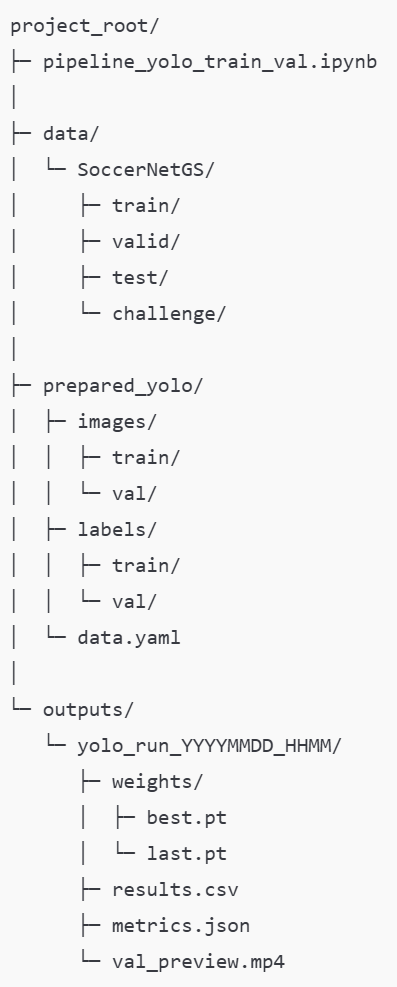

In [31]:
# Config (edit these only)

from pathlib import Path
import os, json, shutil, time
from datetime import datetime
from collections import defaultdict

# -------- Paths (project root = where this notebook lives) --------
PROJECT_ROOT = Path(".").resolve()
DATA_ROOT    = PROJECT_ROOT / "data" / "SoccerNetGS"

#PREPARED_DIR = PROJECT_ROOT / "prepared_yolo"
#OUTPUTS_DIR  = PROJECT_ROOT / "outputs"
PREPARED_DIR = Path(r"C:\Users\USER\DLProject\prepared_yolo")
OUTPUTS_DIR  = Path(r"C:\Users\USER\DLProject\outputs")

# -------- Export settings --------
KEEP_NAMES = ["player", "goalkeeper", "referee", "ball", "other"]  # YOLO classes
FRAME_STRIDE_EXPORT = 5     
TRAIN_MAX_CLIPS = 25        # None = all clips; or integer for quick tests
VALID_MAX_CLIPS = 10        # None = all clips; or integer for quick tests

MIN_BOX_AREA = 10             # filter tiny boxes (in pixels^2); adjust if needed
PAD = 0                       # optional padding around bbox

# -------- Training settings --------
BASE_MODEL = "yolov8n.pt"      
IMGSZ = 512                    
EPOCHS = 40
BATCH = 8 
WORKERS = 0
DEVICE = "cuda"

# -------- Preview video settings --------
PREVIEW_CLIP_ID = "SNGS-021"   # must exist under data/SoccerNetGS/valid/<CLIP_ID>
PREVIEW_CONF = 0.25
PREVIEW_STRIDE = 1            # set 2/5 for faster video generation
PREVIEW_FPS = 25

# -------- Run folder (unique per run) --------
RUN_NAME = datetime.now().strftime("yolo_run_%Y%m%d_%H%M")
RUN_DIR = OUTPUTS_DIR / RUN_NAME

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT:", DATA_ROOT)
print("PREPARED_DIR:", PREPARED_DIR)
print("RUN_DIR:", RUN_DIR)


PROJECT_ROOT: C:\Users\USER\Documents
DATA_ROOT: C:\Users\USER\Documents\data\SoccerNetGS
PREPARED_DIR: C:\Users\USER\DLProject\prepared_yolo
RUN_DIR: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200


## Step 1 — Helper functions (export + YAML + preview video)

This cell defines:
- a YOLO dataset exporter from SoccerNetGS `Labels-GameState.json`
- a writer for `prepared_yolo/data.yaml`
- a small helper to render a `val_preview.mp4` using YOLO predictions


In [32]:
# Helpers

import cv2
import numpy as np

def list_label_files(data_root: Path, split: str, max_clips=None):
    split_dir = data_root / split
    files = sorted(split_dir.rglob("Labels-GameState.json"))
    if max_clips is not None:
        files = files[:max_clips]
    return files

def crop_xywh(img, x, y, w, h, pad=0):
    H, W = img.shape[:2]
    x1 = int(max(0, x - pad))
    y1 = int(max(0, y - pad))
    x2 = int(min(W - 1, x + w + pad))
    y2 = int(min(H - 1, y + h + pad))
    if x2 <= x1 or y2 <= y1:
        return None
    return img[y1:y2, x1:x2]

import os
import stat
import time
import shutil
from pathlib import Path

def _rmtree_onerror(func, path, exc_info):
    """
    Windows fix: if a file/dir is read-only, make it writable then retry.
    """
    try:
        os.chmod(path, stat.S_IWRITE)
    except Exception:
        pass
    func(path)

def reset_prepared_dir(prepared_dir: Path):
    prepared_dir = Path(prepared_dir)

    if prepared_dir.exists():
        backup = prepared_dir.with_name(
            prepared_dir.name + "_old_" + datetime.now().strftime("%Y%m%d_%H%M%S")
        )
        prepared_dir.rename(backup)   # avoids WinError 5 locks

    (prepared_dir / "images" / "train").mkdir(parents=True, exist_ok=True)
    (prepared_dir / "images" / "val").mkdir(parents=True, exist_ok=True)
    (prepared_dir / "labels" / "train").mkdir(parents=True, exist_ok=True)
    (prepared_dir / "labels" / "val").mkdir(parents=True, exist_ok=True)


def write_data_yaml(prepared_dir: Path, keep_names):
    data_yaml = prepared_dir / "data.yaml"
    names = {i: n for i, n in enumerate(keep_names)}
    content = {
        "path": str(prepared_dir).replace("\\", "/"),
        "train": "images/train",
        "val": "images/val",
        "names": names
    }
    # Write YAML manually
    lines = []
    lines.append(f'path: "{content["path"]}"')
    lines.append(f'train: {content["train"]}')
    lines.append(f'val: {content["val"]}')
    lines.append("names:")
    for k, v in names.items():
        lines.append(f"  {k}: {v}")
    data_yaml.write_text("\n".join(lines) + "\n", encoding="utf-8")
    return data_yaml

def export_split_to_yolo(
    src_split: str, dst_split: str,
    data_root: Path, prepared_dir: Path,
    keep_names,
    frame_stride: int = 1,
    max_clips=None,
    min_box_area: int = 10,
    pad: int = 0,
):
    label_files = list_label_files(data_root, src_split, max_clips=max_clips)
    print(f"{src_split}: using {len(label_files)} clips")

    name_to_yolo = {n: i for i, n in enumerate(keep_names)}
    saved_images = 0
    saved_labels = 0
    skipped = defaultdict(int)

    for labels_path in label_files:
        seq_dir = labels_path.parent
        clip_id = seq_dir.name

        labels = json.loads(labels_path.read_text(encoding="utf-8"))
        cat_id_to_name = {c["id"]: c["name"] for c in labels["categories"]}

        # image_id -> filename
        img_id_to_name = {im["image_id"]: im["file_name"] for im in labels["images"]}
        img_dir = seq_dir / labels["info"]["im_dir"]  # usually img1

        # group annotations per frame
        anns_by_img = defaultdict(list)
        for a in labels["annotations"]:
            if a.get("supercategory") != "object":
                continue

            cat_name = cat_id_to_name.get(a.get("category_id"))
            if cat_name is None:
                skipped["unknown_category"] += 1
                continue

            # map SoccerNetGS categories into keep set
            # everything not in KEEP_NAMES becomes "other" if "other" exists
            if cat_name not in name_to_yolo:
                if "other" in name_to_yolo:
                    cat_name = "other"
                else:
                    skipped["dropped_category"] += 1
                    continue

            b = a.get("bbox_image")
            if not b:
                skipped["missing_bbox"] += 1
                continue

            x, y, w, h = b["x"], b["y"], b["w"], b["h"]
            if w * h < min_box_area:
                skipped["too_small"] += 1
                continue

            anns_by_img[a["image_id"]].append((cat_name, x, y, w, h))

        # export frame by frame
        img_ids_sorted = sorted(img_id_to_name.keys())
        for idx, img_id in enumerate(img_ids_sorted):
            if frame_stride > 1 and (idx % frame_stride != 0):
                continue

            fname = img_id_to_name.get(img_id)
            if not fname:
                skipped["missing_frame_name"] += 1
                continue

            frame_path = img_dir / fname
            if not frame_path.exists():
                skipped["missing_frame_file"] += 1
                continue

            frame = cv2.imread(str(frame_path))
            if frame is None:
                skipped["bad_imread"] += 1
                continue

            H, W = frame.shape[:2]
            frame_stem = Path(fname).stem

            # output paths
            out_img_name = f"{clip_id}_{frame_stem}.jpg"
            out_lbl_name = f"{clip_id}_{frame_stem}.txt"

            out_img_path = prepared_dir / "images" / dst_split / out_img_name
            out_lbl_path = prepared_dir / "labels" / dst_split / out_lbl_name

            # write labels in YOLO format (one txt per image)
            lines = []
            for (cat_name, x, y, w, h) in anns_by_img.get(img_id, []):
                cls = name_to_yolo[cat_name]

                # YOLO wants: x_center, y_center, width, height normalized to [0,1]
                xc = (x + w / 2.0) / W
                yc = (y + h / 2.0) / H
                wn = w / W
                hn = h / H

                # clamp just in case
                xc = max(0.0, min(1.0, xc))
                yc = max(0.0, min(1.0, yc))
                wn = max(0.0, min(1.0, wn))
                hn = max(0.0, min(1.0, hn))

                lines.append(f"{cls} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")

            # if no objects, still write empty label file (YOLO supports it)
            out_lbl_path.write_text("\n".join(lines) + ("\n" if lines else ""), encoding="utf-8")
            cv2.imwrite(str(out_img_path), frame)

            saved_images += 1
            saved_labels += len(lines)

    print(f"{dst_split}: saved_images={saved_images}, total_labels={saved_labels}")
    print("skipped:", dict(skipped))
    return {"saved_images": saved_images, "total_labels": saved_labels, "skipped": dict(skipped)}

def ensure_run_dirs(run_dir: Path):
    (run_dir / "weights").mkdir(parents=True, exist_ok=True)

def make_yolo_clip_video(model, clip_dir: Path, out_mp4: Path, conf=0.25, frame_stride=1, fps=25):
    clip_dir = Path(clip_dir)
    img_dir = clip_dir / "img1"
    frame_paths = sorted(img_dir.glob("*.jpg"))
    if not frame_paths:
        raise RuntimeError(f"No frames found in {img_dir}")

    first = cv2.imread(str(frame_paths[0]))
    if first is None:
        raise RuntimeError("Could not read first frame")
    H, W = first.shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    vw = cv2.VideoWriter(str(out_mp4), fourcc, fps, (W, H))

    for i, fp in enumerate(frame_paths):
        if frame_stride > 1 and (i % frame_stride != 0):
            continue

        frame = cv2.imread(str(fp))
        if frame is None:
            continue

        results = model.predict(source=frame, conf=conf, verbose=False)
        annotated = results[0].plot()  # Ultralytics draws boxes/classes
        vw.write(annotated)

    vw.release()
    print("✅ wrote preview video:", out_mp4)


## Step 2 — Export YOLO dataset to `prepared_yolo/`

This cell:
- wipes and rebuilds `prepared_yolo/`
- exports **all** (or limited) clips from:
  - `data/SoccerNetGS/train` → `prepared_yolo/images/train` + `labels/train`
  - `data/SoccerNetGS/valid` → `prepared_yolo/images/val` + `labels/val`
- writes `prepared_yolo/data.yaml` for Ultralytics


In [33]:
# Export dataset

reset_prepared_dir(PREPARED_DIR)

train_stats = export_split_to_yolo(
    src_split="train",
    dst_split="train",
    data_root=DATA_ROOT,
    prepared_dir=PREPARED_DIR,
    keep_names=KEEP_NAMES,
    frame_stride=FRAME_STRIDE_EXPORT,
    max_clips=TRAIN_MAX_CLIPS,
    min_box_area=MIN_BOX_AREA,
    pad=PAD,
)

val_stats = export_split_to_yolo(
    src_split="valid",
    dst_split="val",
    data_root=DATA_ROOT,
    prepared_dir=PREPARED_DIR,
    keep_names=KEEP_NAMES,
    frame_stride=FRAME_STRIDE_EXPORT,
    max_clips=VALID_MAX_CLIPS,
    min_box_area=MIN_BOX_AREA,
    pad=PAD,
)

data_yaml_path = write_data_yaml(PREPARED_DIR, KEEP_NAMES)

print("✅ Export done")
print("data.yaml:", data_yaml_path)
print("train_stats:", train_stats)
print("val_stats:", val_stats)


train: using 25 clips
train: saved_images=3750, total_labels=67498
skipped: {'too_small': 7}
valid: using 10 clips
val: saved_images=1500, total_labels=22875
skipped: {}
✅ Export done
data.yaml: C:\Users\USER\DLProject\prepared_yolo\data.yaml
train_stats: {'saved_images': 3750, 'total_labels': 67498, 'skipped': {'too_small': 7}}
val_stats: {'saved_images': 1500, 'total_labels': 22875, 'skipped': {}}


## Step 3 — Train YOLO (outputs saved under `outputs/yolo_run_.../`)

This cell:
- creates a new unique run folder in `outputs/`
- runs `model.train(...)`
- copies `best.pt`, `last.pt` into `outputs/.../weights/`
- copies `results.csv` into `outputs/.../results.csv`


In [34]:
# Train YOLO and save key artifacts

from ultralytics import YOLO

OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)
RUN_DIR.mkdir(parents=True, exist_ok=True)
ensure_run_dirs(RUN_DIR)

print("Training run folder:", RUN_DIR)

model = YOLO(BASE_MODEL)

# Force Ultralytics to write inside our RUN_DIR (it will create a subfolder)
train_results = model.train(
    data=str(PREPARED_DIR / "data.yaml"),
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    workers=WORKERS,
    device=DEVICE,
    project=str(RUN_DIR),
    name="ultralytics",   # Ultralytics will write to RUN_DIR/ultralytics/
)

ULTRA_DIR = RUN_DIR / "ultralytics"
print("Ultralytics output dir:", ULTRA_DIR)

# Find where Ultralytics actually wrote
# Common path: RUN_DIR/ultralytics/weights/best.pt, last.pt
best_pt = ULTRA_DIR / "weights" / "best.pt"
last_pt = ULTRA_DIR / "weights" / "last.pt"
results_csv = ULTRA_DIR / "results.csv"

# Copy into our minimal outputs
if best_pt.exists():
    shutil.copy2(best_pt, RUN_DIR / "weights" / "best.pt")
if last_pt.exists():
    shutil.copy2(last_pt, RUN_DIR / "weights" / "last.pt")
if results_csv.exists():
    shutil.copy2(results_csv, RUN_DIR / "results.csv")

print("✅ Copied key artifacts to:", RUN_DIR)
print(" -", RUN_DIR / "weights" / "best.pt")
print(" -", RUN_DIR / "weights" / "last.pt")
print(" -", RUN_DIR / "results.csv")


Training run folder: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200
Ultralytics 8.4.7  Python-3.11.7 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\USER\DLProject\prepared_yolo\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=ultralytics, nbs=64, nms=

## Step 4 — Validate + save `metrics.json`

This cell:
- loads `best.pt`
- runs `model.val(...)` on the exported validation set
- writes a small `metrics.json` into the run folder with key values (mAP, precision, recall)


In [36]:
import numpy as np
import torch
from ultralytics import __version__ as ultralytics_version

print(f"NumPy: {np.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"Ultralytics: {ultralytics_version}")

NumPy: 1.26.4
PyTorch: 2.7.1+cu118
Ultralytics: 8.4.7


In [54]:
RUN_DIR / "weights" / "best.pt"

WindowsPath('C:/Users/USER/DLProject/outputs/yolo_run_20260122_2200/weights/best.pt')

In [55]:
# Validate and write metrics.json

best_path = RUN_DIR / "weights" / "best.pt"
assert best_path.exists(), f"Missing best.pt at {best_path}"

best_model = YOLO(str(best_path))

val_metrics = best_model.val(
    data=str(PREPARED_DIR / "data.yaml"),
    split="val",
    imgsz=IMGSZ,
    device=DEVICE,
    verbose=False,
    workers=0
)


# Ultralytics metrics objects can vary slightly by version.
# These are the common ones for detection:
summary = {}
try:
    summary["map50"] = float(val_metrics.box.map50)
    summary["map50_95"] = float(val_metrics.box.map)
    summary["precision"] = float(val_metrics.box.mp)
    summary["recall"] = float(val_metrics.box.mr)
except Exception as e:
    summary["error"] = f"Could not read standard metrics fields: {e}"
    summary["raw"] = str(val_metrics)

metrics_path = RUN_DIR / "metrics.json"
metrics_path.write_text(json.dumps(summary, indent=2), encoding="utf-8")

print("✅ Wrote metrics:", metrics_path)
print(json.dumps(summary, indent=2))


Ultralytics 8.4.7  Python-3.11.7 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
Model summary (fused): 73 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.30.5 ms, read: 1800.6540.7 MB/s, size: 453.5 KB)
val: Scanning C:\Users\USER\DLProject\prepared_yolo\labels\val.cache... 1500 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1500/1500  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 94/94 2.8it/s 33.9s0.3ss
                   all       1500      22875      0.777      0.672      0.709      0.377
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to C:\Users\USER\Documents\runs\detect\val3
✅ Wrote metrics: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\metrics.json
{
  "map50": 0.7093237542970982,
  "map50_95": 0.37664727631583855,
  "precision": 0.7774979782220701,
  "recall": 0.6722766677199032
}


### Step 5 — Generate `val_preview.mp4` (sanity-check)

This cell:
- takes a single validation clip (e.g. `SNGS-021`)
- runs the trained YOLO model on every frame
- writes `val_preview.mp4` into your run folder

Tip: set `PREVIEW_STRIDE=2` or `5` for faster video creation.


In [38]:
# val_preview.mp4

clip_dir = DATA_ROOT / "valid" / PREVIEW_CLIP_ID
labels_path = clip_dir / "Labels-GameState.json"
assert labels_path.exists(), f"Clip not found or missing labels: {labels_path}"

preview_path = RUN_DIR / "val_preview.mp4"

make_yolo_clip_video(
    model=best_model,
    clip_dir=clip_dir,
    out_mp4=preview_path,
    conf=PREVIEW_CONF,
    frame_stride=PREVIEW_STRIDE,
    fps=PREVIEW_FPS,
)

print("✅ Preview saved to:", preview_path)


✅ wrote preview video: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\val_preview.mp4
✅ Preview saved to: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\val_preview.mp4


## ResNet18

### ResNet18 setup (config + paths)

This cell defines where ResNet18 artifacts will be saved inside the current `RUN_DIR`, and sets basic training and overlay parameters (epochs, batch size, crop padding, and whether to use CPU/GPU).

It does not train anything yet — it just prepares variables used by later cells.


In [ ]:
from pathlib import Path
import json

# --- Where to store ResNet artifacts for THIS YOLO run ---
RESNET_DIR = RUN_DIR / "resnet18"
RESNET_DIR.mkdir(parents=True, exist_ok=True)

RESNET_WEIGHTS_PATH = RESNET_DIR / "resnet18_crop_best.pt"
RESNET_META_PATH    = RESNET_DIR / "resnet18_meta.json"
RESNET_METRICS_PATH = RESNET_DIR / "resnet18_metrics.json"

# --- Crop dataset cache location (built from prepared YOLO export) ---
CROPS_DIR = RESNET_DIR / "crops_resnet18_team"  # ImageFolder-friendly: crops_resnet18/train/<class>/...

# --- Crop + overlay params ---
CROP_PAD_FOR_RESNET = 6          # add context around bbox
RESNET_MIN_CROP_PIXELS = 10      # skip tiny crops (helps stability)

# --- Training hyperparams  ---
RESNET_EPOCHS = 6
RESNET_BATCH  = 64
RESNET_LR     = 3e-4

print("✅ RESNET_DIR:", RESNET_DIR)
print("✅ CROPS_DIR :", CROPS_DIR)
print("✅ WEIGHTS   :", RESNET_WEIGHTS_PATH)


✅ RESNET_DIR: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18
✅ CROPS_DIR : C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\crops_resnet18_team
✅ WEIGHTS   : C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\resnet18_crop_best.pt


### Build a crop cache for ResNet18 from the prepared YOLO dataset

This cell creates a classification dataset by cropping ground-truth objects from the YOLO-exported dataset:
- reads images from `PREPARED_DIR/images/{train,val}`
- reads labels from `PREPARED_DIR/labels/{train,val}`
- saves crops into `CROPS_DIR/{train,val}/<class_name>/*.jpg`

It only writes missing files, so re-running it is fast (acts like a cache).


In [40]:
# =========================
# Build TEAM crop cache (left/right) FROM RAW SoccerNetGS labels
# =========================
from pathlib import Path
import json
import cv2
from collections import defaultdict
import shutil

def build_team_crop_cache_from_raw(
    data_root: Path,
    crops_dir: Path,
    max_clips_train=None,
    max_clips_valid=None,
    frame_stride: int = 1,
    pad: int = 6,
    min_pixels: int = 10,
    min_box_area: int = 10,
    team_targets=("player", "goalkeeper"),
):
    """
    Builds an ImageFolder dataset for ResNet TEAM classification:
      crops_dir/train/left, crops_dir/train/right
      crops_dir/val/left,   crops_dir/val/right

    Uses Labels-GameState.json so we can read attributes.team.

    Notes:
      - Only crops 'player' and 'goalkeeper' (team_targets) because those have team labels.
      - Skips annotations missing team or with unknown team values.
    """
    data_root = Path(data_root)
    crops_dir = Path(crops_dir)

    # Start fresh to avoid mixing old labels
    if crops_dir.exists():
        shutil.rmtree(crops_dir)

    # Create folder structure
    for split in ["train", "val"]:
        for team in ["left", "right"]:
            (crops_dir / split / team).mkdir(parents=True, exist_ok=True)

    TEAM_ALIASES = {
        "left": "left",
        "right": "right",
        "team_left": "left",
        "team_right": "right",
        "home": "left",
        "away": "right",
    }

    def list_label_files(split_name: str, max_clips=None):
        split_dir = data_root / split_name
        files = sorted(split_dir.rglob("Labels-GameState.json"))
        if max_clips is not None:
            files = files[:max_clips]
        return files

    def process_split(src_split: str, dst_split: str, max_clips=None):
        label_files = list_label_files(src_split, max_clips=max_clips)
        print(f"[team-crops] {src_split} -> {dst_split}: using {len(label_files)} clips")

        saved = 0
        skipped = defaultdict(int)

        for labels_path in label_files:
            seq_dir = labels_path.parent
            clip_id = seq_dir.name

            labels = json.loads(labels_path.read_text(encoding="utf-8"))
            cat_id_to_name = {c["id"]: c["name"] for c in labels["categories"]}

            # image_id -> file_name
            img_id_to_name = {im["image_id"]: im["file_name"] for im in labels["images"]}
            img_dir = seq_dir / labels["info"]["im_dir"]  # usually img1

            # group relevant annotations by image_id
            anns_by_img = defaultdict(list)
            for a in labels["annotations"]:
                if a.get("supercategory") != "object":
                    continue

                cat_name = cat_id_to_name.get(a.get("category_id"))
                if cat_name not in team_targets:
                    continue  # only player/goalkeeper for team classifier

                attrs = a.get("attributes") or {}
                team_raw = attrs.get("team", None)
                if team_raw is None:
                    skipped["missing_team"] += 1
                    continue

                team = TEAM_ALIASES.get(str(team_raw).lower(), None)
                if team not in ("left", "right"):
                    skipped["unknown_team"] += 1
                    continue

                b = a.get("bbox_image")
                if not b:
                    skipped["missing_bbox"] += 1
                    continue

                x, y, w, h = b["x"], b["y"], b["w"], b["h"]
                if w * h < min_box_area:
                    skipped["too_small_area"] += 1
                    continue

                anns_by_img[a["image_id"]].append((team, x, y, w, h))

            # iterate frames (optionally strided)
            img_ids_sorted = sorted(img_id_to_name.keys())
            for idx, img_id in enumerate(img_ids_sorted):
                if frame_stride > 1 and (idx % frame_stride != 0):
                    continue

                fname = img_id_to_name.get(img_id)
                if not fname:
                    skipped["missing_frame_name"] += 1
                    continue

                frame_path = img_dir / fname
                if not frame_path.exists():
                    skipped["missing_frame_file"] += 1
                    continue

                frame = cv2.imread(str(frame_path))
                if frame is None:
                    skipped["bad_imread"] += 1
                    continue

                H, W = frame.shape[:2]
                frame_stem = Path(fname).stem

                anns = anns_by_img.get(img_id, [])
                for j, (team, x, y, w, h) in enumerate(anns):
                    # pad + clip
                    x1 = int(max(0, x - pad))
                    y1 = int(max(0, y - pad))
                    x2 = int(min(W - 1, x + w + pad))
                    y2 = int(min(H - 1, y + h + pad))
                    if x2 <= x1 or y2 <= y1:
                        skipped["bad_box"] += 1
                        continue

                    crop = frame[y1:y2, x1:x2]
                    if crop.shape[0] < min_pixels or crop.shape[1] < min_pixels:
                        skipped["too_small_crop"] += 1
                        continue

                    out_path = crops_dir / dst_split / team / f"{clip_id}_{frame_stem}_{j:02d}.jpg"
                    if not out_path.exists():
                        cv2.imwrite(str(out_path), crop)
                    saved += 1

        print(f"[team-crops] {dst_split}: saved={saved} skipped={dict(skipped)}")

    # SoccerNetGS uses "valid" as the validation split folder
    process_split("train", "train", max_clips=max_clips_train)
    process_split("valid", "val",   max_clips=max_clips_valid)

    print("✅ Team crop cache ready at:", crops_dir)
    print("   Expected folders:", crops_dir / "train" / "left", "and", crops_dir / "train" / "right")


# Build crops for ResNet team classifier
build_team_crop_cache_from_raw(
    data_root=DATA_ROOT,
    crops_dir=CROPS_DIR,
    max_clips_train=TRAIN_MAX_CLIPS,
    max_clips_valid=VALID_MAX_CLIPS,
    frame_stride=FRAME_STRIDE_EXPORT,
    pad=CROP_PAD_FOR_RESNET,
    min_pixels=RESNET_MIN_CROP_PIXELS,
    min_box_area=MIN_BOX_AREA,
    team_targets=("player", "goalkeeper"),
)


[team-crops] train -> train: using 25 clips
[team-crops] train: saved=58320 skipped={'too_small_crop': 5, 'too_small_area': 5}
[team-crops] valid -> val: using 10 clips
[team-crops] val: saved=19976 skipped={}
✅ Team crop cache ready at: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\crops_resnet18_team
   Expected folders: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\crops_resnet18_team\train\left and C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\crops_resnet18_team\train\right


In [41]:
from pathlib import Path
import shutil

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def count_images_in_dir(d: Path) -> int:
    if not d.exists() or not d.is_dir():
        return 0
    n = 0
    for p in d.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            n += 1
    return n

def prune_empty_class_dirs(crops_dir: Path):
    crops_dir = Path(crops_dir)
    for split in ["train", "val"]:
        split_dir = crops_dir / split
        if not split_dir.exists():
            print(f"⚠️ Missing split dir: {split_dir}")
            continue

        removed = []
        kept = []

        for class_dir in sorted([p for p in split_dir.iterdir() if p.is_dir()]):
            n = count_images_in_dir(class_dir)
            if n == 0:
                shutil.rmtree(class_dir)
                removed.append(class_dir.name)
            else:
                kept.append((class_dir.name, n))

        print(f"\n[{split}] kept classes (name, #images):")
        for name, n in kept:
            print(f"  - {name}: {n}")

        if removed:
            print(f"[{split}] removed empty classes:", removed)
        else:
            print(f"[{split}] no empty classes removed")

prune_empty_class_dirs(CROPS_DIR)



[train] kept classes (name, #images):
  - left: 28024
  - right: 30296
[train] no empty classes removed

[val] kept classes (name, #images):
  - left: 10023
  - right: 9953
[val] no empty classes removed


### Train ResNet18 on GPU using a pretrained backbone (freeze → partial fine-tune)

This cell trains a ResNet18 classifier on the crop dataset in `CROPS_DIR` using **GPU**.

It starts from **ImageNet-pretrained weights**, replaces the final `fc` layer for our classes, and trains in two phases:
1) Phase 1: freezes the backbone and trains only the final `fc` layer.
2) Phase 2: unfreezes `layer4` + `fc` to adapt higher-level features to soccer crops while staying GPU-friendly.

It saves:
- best weights to `RESNET_WEIGHTS_PATH`
- class index mapping to `RESNET_META_PATH`
- summary metrics (accuracy + confusion matrix) to `RESNET_METRICS_PATH`


In [ ]:
import json
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# ---- Force GPU ----
device = "cuda"

# loaders
RESNET_INPUT_SIZE = 160

train_tfms = transforms.Compose([
    transforms.Resize((RESNET_INPUT_SIZE, RESNET_INPUT_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((RESNET_INPUT_SIZE, RESNET_INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(CROPS_DIR / "train", transform=train_tfms)
print("ResNet classes:", train_ds.classes)

val_ds   = datasets.ImageFolder(CROPS_DIR / "val", transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=RESNET_BATCH, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=RESNET_BATCH, shuffle=False, num_workers=0)

num_classes = len(train_ds.classes)

# Store mapping (ImageFolder assigns indices by sorted folder names)
class_to_idx = train_ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
Path(RESNET_META_PATH).write_text(
    json.dumps({
        "device_used": device,
        "class_to_idx": class_to_idx,
        "idx_to_class": idx_to_class,
        "keep_names": list(KEEP_NAMES),
        "note": "ResNet predicts ImageFolder indices; decode with idx_to_class."
    }, indent=2),
    encoding="utf-8"
)

# ---- Model: ImageNet-pretrained backbone ----
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

def set_trainable(module, trainable: bool):
    for p in module.parameters():
        p.requires_grad = trainable

def evaluate(m):
    m.eval()
    correct, total = 0, 0
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = m(x)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.numel()
            for t, p in zip(y.cpu().numpy(), pred.cpu().numpy()):
                cm[int(t), int(p)] += 1
    return correct / max(1, total), cm


# ---- 2-phase schedule ---- 
PHASE1_EPOCHS = 4
PHASE2_EPOCHS = 2  # set to >0 to fine-tune layer4 as well

best_acc = -1.0
best_cm = None
best_phase = None
best_epoch = None

# ===== Phase 1: train only fc =====
set_trainable(model, False)
set_trainable(model.fc, True)

optimizer = torch.optim.AdamW(model.fc.parameters(), lr=RESNET_LR, weight_decay=1e-4)

print(f"🧠 Phase 1 (GPU): training only fc for {PHASE1_EPOCHS} epoch(s)")
for ep in range(1, PHASE1_EPOCHS + 1):
    model.train()
    running = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        running += loss.item()

    acc, cm = evaluate(model)
    print(f"[P1] epoch {ep}/{PHASE1_EPOCHS} | train_loss={running/max(1,len(train_loader)):.4f} | val_acc={acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_cm = cm.copy()
        best_phase = "phase1"
        best_epoch = ep
        torch.save(model.state_dict(), str(RESNET_WEIGHTS_PATH))

# ===== Phase 2: fine-tune layer4 + fc =====
if PHASE2_EPOCHS > 0:
    set_trainable(model.layer4, True)
    set_trainable(model.fc, True)

    optimizer = torch.optim.AdamW(
        [
            {"params": model.layer4.parameters(), "lr": RESNET_LR * 0.3},
            {"params": model.fc.parameters(),     "lr": RESNET_LR},
        ],
        weight_decay=1e-4
    )

    print(f"🧠 Phase 2 (GPU): fine-tuning layer4 + fc for {PHASE2_EPOCHS} epoch(s)")
    for ep2 in range(1, PHASE2_EPOCHS + 1):
        model.train()
        running = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            running += loss.item()

        acc, cm = evaluate(model)
        print(f"[P2] epoch {ep2}/{PHASE2_EPOCHS} | train_loss={running/max(1,len(train_loader)):.4f} | val_acc={acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_cm = cm.copy()
            best_phase = "phase2"
            best_epoch = ep2
            torch.save(model.state_dict(), str(RESNET_WEIGHTS_PATH))

# Save metrics summary
metrics = {
    "best_val_acc": float(best_acc),
    "best_phase": best_phase,
    "best_epoch_in_phase": int(best_epoch) if best_epoch is not None else None,
    "confusion_matrix_rows_true_cols_pred": best_cm.tolist() if best_cm is not None else None,
    "classes_in_folder_order": train_ds.classes,
    "note": "Confusion matrix indices correspond to classes_in_folder_order."
}
Path(RESNET_METRICS_PATH).write_text(json.dumps(metrics, indent=2), encoding="utf-8")

print("✅ Saved best weights:", RESNET_WEIGHTS_PATH)
print("✅ Saved meta        :", RESNET_META_PATH)
print("✅ Saved metrics     :", RESNET_METRICS_PATH)
print("✅ Best val acc      :", best_acc)


ResNet classes: ['left', 'right']
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:12<00:00, 3.80MB/s]


🧠 Phase 1 (CPU): training only fc for 4 epoch(s)
[P1] epoch 1/4 | train_loss=0.5991 | val_acc=0.6833
[P1] epoch 2/4 | train_loss=0.5528 | val_acc=0.6465
[P1] epoch 3/4 | train_loss=0.5421 | val_acc=0.6761
[P1] epoch 4/4 | train_loss=0.5354 | val_acc=0.6851
🧠 Phase 2 (CPU): fine-tuning layer4 + fc for 2 epoch(s)
[P2] epoch 1/2 | train_loss=0.1997 | val_acc=0.6349
[P2] epoch 2/2 | train_loss=0.0818 | val_acc=0.6566
✅ Saved best weights: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\resnet18_crop_best.pt
✅ Saved meta        : C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\resnet18_meta.json
✅ Saved metrics     : C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\resnet18_metrics.json
✅ Best val acc      : 0.6850720865038046


### Create a preview video showing YOLO + ResNet18 predictions (no overriding)

This cell loads the trained ResNet18 weights and then creates a preview video for `PREVIEW_CLIP_ID`.

For each YOLO detection box, it overlays:
- YOLO class + YOLO confidence
- ResNet18 class + ResNet18 confidence (computed from a crop of the same box)

Important: YOLO predictions are NOT modified — ResNet is displayed alongside only.
The output is saved as `val_preview_yolo_plus_resnet18.mp4` inside `RUN_DIR`.


In [43]:
import json
from pathlib import Path
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms

def load_resnet18_for_inference(weights_path: Path, meta_path: Path, device="cuda"):
    meta = json.loads(Path(meta_path).read_text(encoding="utf-8"))
    # JSON keys may come back as strings; normalize to int -> str mapping
    idx_to_class_raw = meta["idx_to_class"]
    idx_to_class = {int(k): v for k, v in idx_to_class_raw.items()}

    num_classes = len(meta["class_to_idx"])

    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(str(weights_path), map_location=device))
    model = model.to(device).eval()

    tfm = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((RESNET_INPUT_SIZE, RESNET_INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])
    return model, tfm, idx_to_class

def resnet_predict_crop(model, tfm, device, crop_bgr):
    crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
    x = tfm(crop_rgb).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)[0]
        probs = torch.softmax(logits, dim=0)
        cls = int(torch.argmax(probs).item())
        conf = float(probs[cls].item())
    return cls, conf

def draw_label(img, x1, y1, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.55
    thickness = 2
    (tw, th), _ = cv2.getTextSize(text, font, scale, thickness)

    y_text = max(0, y1 - 6)
    x2 = min(img.shape[1]-1, x1 + tw + 6)
    y2 = min(img.shape[0]-1, y_text + th + 8)

    cv2.rectangle(img, (x1, y_text), (x2, y2), (0, 0, 0), -1)
    cv2.putText(img, text, (x1 + 3, y_text + th + 5), font, scale, (255, 255, 255), thickness, cv2.LINE_AA)

def make_yolo_plus_resnet_video(
    yolo_model,
    resnet_model, resnet_tfm, idx_to_class,
    clip_dir: Path,
    out_mp4: Path,
    device="cuda",
    yolo_conf=0.25,
    frame_stride=1,
    fps=25,
    crop_pad=6,
    min_crop_pixels=10
):
    clip_dir = Path(clip_dir)
    img_dir = clip_dir / "img1"
    frame_paths = sorted(img_dir.glob("*.jpg"))
    if not frame_paths:
        raise RuntimeError(f"No frames found in {img_dir}")

    first = cv2.imread(str(frame_paths[0]))
    if first is None:
        raise RuntimeError("Could not read first frame")
    H, W = first.shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    vw = cv2.VideoWriter(str(out_mp4), fourcc, fps, (W, H))

    for i, fp in enumerate(frame_paths):
        if frame_stride > 1 and (i % frame_stride != 0):
            continue

        frame = cv2.imread(str(fp))
        if frame is None:
            continue

        result = yolo_model.predict(source=frame, conf=yolo_conf, verbose=False)[0]
        annotated = frame.copy()

        boxes = result.boxes
        if boxes is not None and len(boxes) > 0:
            xyxy = boxes.xyxy.cpu().numpy().astype(int)
            cls  = boxes.cls.cpu().numpy().astype(int)
            conf = boxes.conf.cpu().numpy()

            for (x1, y1, x2, y2), c, s in zip(xyxy, cls, conf):
                # YOLO label
                yolo_name = KEEP_NAMES[c] if 0 <= c < len(KEEP_NAMES) else f"class{c}"
                yolo_score = float(s)

                # Crop for ResNet
                x1p = max(0, x1 - crop_pad); y1p = max(0, y1 - crop_pad)
                x2p = min(W - 1, x2 + crop_pad); y2p = min(H - 1, y2 + crop_pad)
                crop = frame[y1p:y2p, x1p:x2p]

                rn_text = "RN18: (skip)"
                if crop.size > 0 and crop.shape[0] >= min_crop_pixels and crop.shape[1] >= min_crop_pixels:
                    rn_cls, rn_conf = resnet_predict_crop(resnet_model, resnet_tfm, device, crop)
                    rn_name = idx_to_class.get(rn_cls, f"idx{rn_cls}")
                    rn_text = f"RN18: {rn_name} {rn_conf:.2f}"

                # Draw bbox + combined label
                cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = f"YOLO: {yolo_name} {yolo_score:.2f} | {rn_text}"
                draw_label(annotated, x1, y1, label)

        vw.write(annotated)

    vw.release()
    print("✅ wrote video:", out_mp4)

# ---- Load ResNet and create the combined preview video ----
assert RESNET_WEIGHTS_PATH.exists(), f"Missing ResNet weights: {RESNET_WEIGHTS_PATH}"
assert RESNET_META_PATH.exists(), f"Missing ResNet meta: {RESNET_META_PATH}"

resnet_device = "cuda"
resnet_model, resnet_tfm, idx_to_class = load_resnet18_for_inference(
    RESNET_WEIGHTS_PATH, RESNET_META_PATH, device=resnet_device
)

clip_dir = DATA_ROOT / "valid" / PREVIEW_CLIP_ID
out_path = RUN_DIR / "val_preview_yolo_plus_resnet18.mp4"

make_yolo_plus_resnet_video(
    yolo_model=best_model,
    resnet_model=resnet_model,
    resnet_tfm=resnet_tfm,
    idx_to_class=idx_to_class,
    clip_dir=clip_dir,
    out_mp4=out_path,
    device=resnet_device,
    yolo_conf=PREVIEW_CONF,
    frame_stride=PREVIEW_STRIDE,
    fps=PREVIEW_FPS,
    crop_pad=CROP_PAD_FOR_RESNET,
    min_crop_pixels=RESNET_MIN_CROP_PIXELS
)


✅ wrote video: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\val_preview_yolo_plus_resnet18.mp4


In [44]:
# =========================
# YOLO + ResNet TEAM video (keeps ball/referee; colors player+keeper by team)
# =========================

import json
from pathlib import Path
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms


def load_resnet18_for_inference(weights_path: Path, meta_path: Path, device="cuda"):
    meta = json.loads(Path(meta_path).read_text(encoding="utf-8"))
    idx_to_class_raw = meta["idx_to_class"]
    idx_to_class = {int(k): v for k, v in idx_to_class_raw.items()}

    num_classes = len(meta["class_to_idx"])

    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(str(weights_path), map_location=device))
    model = model.to(device).eval()

    tfm = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((RESNET_INPUT_SIZE, RESNET_INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])
    return model, tfm, idx_to_class


def resnet_predict_crop(model, tfm, device, crop_bgr):
    crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
    x = tfm(crop_rgb).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)[0]
        probs = torch.softmax(logits, dim=0)
        cls = int(torch.argmax(probs).item())
        conf = float(probs[cls].item())
    return cls, conf


def draw_label(img, x1, y1, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.55
    thickness = 2
    (tw, th), _ = cv2.getTextSize(text, font, scale, thickness)

    y_text = max(0, y1 - 6)
    x2 = min(img.shape[1]-1, x1 + tw + 6)
    y2 = min(img.shape[0]-1, y_text + th + 8)

    cv2.rectangle(img, (x1, y_text), (x2, y2), (0, 0, 0), -1)
    cv2.putText(img, text, (x1 + 3, y_text + th + 5), font, scale,
                (255, 255, 255), thickness, cv2.LINE_AA)


def make_yolo_plus_resnet_video(
    yolo_model,
    resnet_model, resnet_tfm, idx_to_class,
    clip_dir: Path,
    out_mp4: Path,
    device="cuda",
    yolo_conf=0.25,
    frame_stride=1,
    fps=25,
    crop_pad=6,
    min_crop_pixels=10,
    team_targets=("player", "goalkeeper"),
):
    """
    - Draw YOLO boxes + (class, conf) for ALL detections
    - For player+goalkeeper only: run ResNet and color box by predicted team + show RN conf
    """

    TEAM_NAME_MAP = {
        "left": "Left",
        "right": "Right",
        "team_left": "Left",
        "team_right": "Right",
        "home": "Left",
        "away": "Right",
    }

    # Box colours (BGR)
    TEAM_COLOR = {
        "Left": (255, 0, 0),   # blue
        "Right": (0, 0, 255),  # red
    }
    OTHER_COLOR = (0, 255, 0)     # green for non-team objects
    UNKNOWN_TEAM_COLOR = (0, 255, 255)  # yellow if RN label not mapped

    clip_dir = Path(clip_dir)
    img_dir = clip_dir / "img1"
    frame_paths = sorted(img_dir.glob("*.jpg"))
    if not frame_paths:
        raise RuntimeError(f"No frames found in {img_dir}")

    first = cv2.imread(str(frame_paths[0]))
    if first is None:
        raise RuntimeError("Could not read first frame")
    H, W = first.shape[:2]

    out_mp4 = Path(out_mp4)
    out_mp4.parent.mkdir(parents=True, exist_ok=True)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    vw = cv2.VideoWriter(str(out_mp4), fourcc, fps, (W, H))

    # Helper: YOLO class name robustly
    def yolo_class_name(c_int: int) -> str:
        if hasattr(yolo_model, "names") and isinstance(yolo_model.names, dict):
            return yolo_model.names.get(c_int, f"class{c_int}")
        # fallback to your config list
        if 0 <= c_int < len(KEEP_NAMES):
            return KEEP_NAMES[c_int]
        return f"class{c_int}"

    for i, fp in enumerate(frame_paths):
        if frame_stride > 1 and (i % frame_stride != 0):
            continue

        frame = cv2.imread(str(fp))
        if frame is None:
            continue

        result = yolo_model.predict(source=frame, conf=yolo_conf, verbose=False)[0]
        annotated = frame.copy()

        boxes = result.boxes
        if boxes is not None and len(boxes) > 0:
            xyxy = boxes.xyxy.cpu().numpy().astype(int)
            cls  = boxes.cls.cpu().numpy().astype(int)
            confs = boxes.conf.cpu().numpy()

            for (x1, y1, x2, y2), c, s in zip(xyxy, cls, confs):
                c = int(c)
                yname = yolo_class_name(c)
                yscore = float(s)

                # Default label and color (non-team objects: ball/referee/etc.)
                box_color = OTHER_COLOR
                label = f"{yname} {yscore:.2f}"

                # Only player/goalkeeper get ResNet team overlay + coloured box
                if yname in team_targets:
                    # Crop for ResNet
                    x1p = max(0, x1 - crop_pad); y1p = max(0, y1 - crop_pad)
                    x2p = min(W - 1, x2 + crop_pad); y2p = min(H - 1, y2 + crop_pad)
                    crop = frame[y1p:y2p, x1p:x2p]

                    if crop.size > 0 and crop.shape[0] >= min_crop_pixels and crop.shape[1] >= min_crop_pixels:
                        rn_cls, rn_conf = resnet_predict_crop(resnet_model, resnet_tfm, device, crop)
                        rn_raw = idx_to_class.get(int(rn_cls), f"idx{int(rn_cls)}")
                        team = TEAM_NAME_MAP.get(str(rn_raw).lower(), rn_raw)

                        # Color by team if it's Left/Right
                        if team in TEAM_COLOR:
                            box_color = TEAM_COLOR[team]
                        else:
                            box_color = UNKNOWN_TEAM_COLOR

                        label = f"{yname} {yscore:.2f} | TEAM {team} {rn_conf:.2f}"
                    else:
                        label = f"{yname} {yscore:.2f} | TEAM (skip)"
                        box_color = UNKNOWN_TEAM_COLOR

                # Draw box + label
                cv2.rectangle(annotated, (x1, y1), (x2, y2), box_color, 2)
                draw_label(annotated, x1, y1, label)

        vw.write(annotated)

    vw.release()
    print("✅ wrote video:", out_mp4)


# ---- Load ResNet and create the combined TEAM preview video ----
assert RESNET_WEIGHTS_PATH.exists(), f"Missing ResNet weights: {RESNET_WEIGHTS_PATH}"
assert RESNET_META_PATH.exists(), f"Missing ResNet meta: {RESNET_META_PATH}"

resnet_device = "cuda" if torch.cuda.is_available() else "cpu"
resnet_model, resnet_tfm, idx_to_class = load_resnet18_for_inference(
    RESNET_WEIGHTS_PATH, RESNET_META_PATH, device=resnet_device
)

clip_dir = DATA_ROOT / "valid" / PREVIEW_CLIP_ID
out_path = RUN_DIR / "val_preview_yolo_plus_resnet18_TEAM.mp4"

make_yolo_plus_resnet_video(
    yolo_model=best_model,
    resnet_model=resnet_model,
    resnet_tfm=resnet_tfm,
    idx_to_class=idx_to_class,
    clip_dir=clip_dir,
    out_mp4=out_path,
    device=resnet_device,
    yolo_conf=PREVIEW_CONF,
    frame_stride=PREVIEW_STRIDE,
    fps=PREVIEW_FPS,
    crop_pad=CROP_PAD_FOR_RESNET,
    min_crop_pixels=RESNET_MIN_CROP_PIXELS,
    team_targets=("player", "goalkeeper"),
)

print("✅ TEAM preview saved to:", out_path)


✅ wrote video: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\val_preview_yolo_plus_resnet18_TEAM.mp4
✅ TEAM preview saved to: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\val_preview_yolo_plus_resnet18_TEAM.mp4


In [45]:
PREVIEW_CLIP_ID = "SNGS-030"
clip_dir = DATA_ROOT / "valid" / PREVIEW_CLIP_ID
out_path = RUN_DIR / "val_preview_yolo_plus_resnet18_TEAM2.mp4"

make_yolo_plus_resnet_video(
    yolo_model=best_model,
    resnet_model=resnet_model,
    resnet_tfm=resnet_tfm,
    idx_to_class=idx_to_class,
    clip_dir=clip_dir,
    out_mp4=out_path,
    device=resnet_device,
    yolo_conf=PREVIEW_CONF,
    frame_stride=PREVIEW_STRIDE,
    fps=PREVIEW_FPS,
    crop_pad=CROP_PAD_FOR_RESNET,
    min_crop_pixels=RESNET_MIN_CROP_PIXELS,
    team_targets=("player", "goalkeeper"),
)

print("✅ TEAM preview saved to:", out_path)

✅ wrote video: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\val_preview_yolo_plus_resnet18_TEAM2.mp4
✅ TEAM preview saved to: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\val_preview_yolo_plus_resnet18_TEAM2.mp4


## Application to test clips

In [56]:
# === Run on TEST: create a team-labeled video for one test clip ===

from pathlib import Path

# Pick a test clip id that exists under data/SoccerNetGS/test/
# Example: "SNGS-060"
TEST_CLIP_ID = "SNGS-116"   # <-- change this

test_clip_dir = DATA_ROOT / "test" / TEST_CLIP_ID
assert (test_clip_dir / "img1").exists(), f"Missing test clip frames: {test_clip_dir/'img1'}"

out_test_video = RUN_DIR / f"{TEST_CLIP_ID}_test_yolo_plus_resnet18_TEAM.mp4"

# Use your existing make_yolo_plus_resnet_video function
make_yolo_plus_resnet_video(
    yolo_model=best_model,                 # or yolo_model
    resnet_model=resnet_model,
    resnet_tfm=resnet_tfm,
    idx_to_class=idx_to_class,
    clip_dir=test_clip_dir,
    out_mp4=out_test_video,
    device=resnet_device,
    yolo_conf=0.25,
    frame_stride=1,                        # increase to 2/5 if you want faster
    fps=25,
    crop_pad=CROP_PAD_FOR_RESNET,
    min_crop_pixels=RESNET_MIN_CROP_PIXELS,
    team_targets=("player", "goalkeeper"),
)

print("✅ Wrote test video:", out_test_video)


KeyboardInterrupt: 

## Run on test data

In [52]:
import os
from pathlib import Path

# Where your model should be (from training config)
model_location = Path(r"C:\Users\USER\DLProject\outputs")
print(f"Model location exists: {model_location.exists()}")

if model_location.exists():
    print("\nRun folders:")
    for folder in model_location.iterdir():
        if folder.is_dir() and folder.name.startswith("yolo_run"):
            print(f"  - {folder.name}")

Model location exists: True

Run folders:
  - yolo_run_20260122_2115
  - yolo_run_20260122_2152
  - yolo_run_20260122_2200


In [67]:
# =========================
# Load trained YOLO + trained ResNet(team) from disk and generate a TEAM overlay video
# =========================

from pathlib import Path
import json
import cv2
import numpy as np
import shutil
import torch
import torch.nn as nn
from torchvision import models, transforms

# Hard-coded roots
PROJECT_ROOT = Path(".").resolve()
DATA_ROOT    = PROJECT_ROOT / "data" / "SoccerNetGS"
OUTPUTS_ROOT = PROJECT_ROOT / "outputs"
VIDEOS_DIR   = OUTPUTS_ROOT / "videos"

# Sanity checks
assert PROJECT_ROOT.exists(), f"PROJECT_ROOT not found: {PROJECT_ROOT}"
assert DATA_ROOT.exists(), f"DATA_ROOT not found: {DATA_ROOT}"
for s in ["train", "valid", "test"]:
    assert (DATA_ROOT / s).exists(), f"Missing split folder: {DATA_ROOT/s}"
assert OUTPUTS_ROOT.exists(), f"OUTPUTS_ROOT not found: {OUTPUTS_ROOT}"
VIDEOS_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT   :", DATA_ROOT)
print("OUTPUTS_ROOT:", OUTPUTS_ROOT)

# Find latest YOLO + ResNet artifacts inside outputs
def newest_file(glob_pattern: str, search_root: Path) -> Path | None:
    files = list(search_root.rglob(glob_pattern))
    if not files:
        return None
    return max(files, key=lambda p: p.stat().st_mtime)

# YOLO best weights
# yolo_best = newest_file("weights/best.pt", OUTPUTS_ROOT) #or newest_file("best.pt", OUTPUTS_ROOT)
yolo_best = Path(r"C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\weights\best.pt")
# ResNet team weights/meta
#resnet_w = newest_file("*resnet18*best*.pt", OUTPUTS_ROOT)
resnet_w = Path(r"C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\resnet18_crop_best.pt")
#resnet_m = newest_file("*resnet18*_meta*.json", OUTPUTS_ROOT)
resnet_m = Path(r"C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\resnet18_meta.json")

#assert yolo_best is not None, f"Could not find YOLO best.pt under: {OUTPUTS_ROOT}"
#assert resnet_w  is not None, f"Could not find ResNet best .pt under: {OUTPUTS_ROOT}"
#assert resnet_m  is not None, f"Could not find ResNet meta .json under: {OUTPUTS_ROOT}"

print("✅ Using YOLO weights :", yolo_best)
print("✅ Using ResNet weights:", resnet_w)
print("✅ Using ResNet meta   :", resnet_m)

# Load YOLO model
from ultralytics import YOLO
yolo_model = YOLO(str(yolo_best))

# Load ResNet(team) model + transforms from meta
def load_resnet18_for_inference(weights_path: Path, meta_path: Path, device: torch.device):
    meta = json.loads(Path(meta_path).read_text(encoding="utf-8"))

    idx_to_class_raw = meta.get("idx_to_class", {})
    idx_to_class = {int(k): v for k, v in idx_to_class_raw.items()}

    class_to_idx = meta.get("class_to_idx", None)
    num_classes = len(class_to_idx) if isinstance(class_to_idx, dict) else len(idx_to_class)

    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    state = torch.load(str(weights_path), map_location=device)
    model.load_state_dict(state)
    model = model.to(device).eval()

    tfm = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])
    return model, tfm, idx_to_class

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model, resnet_tfm, idx_to_class = load_resnet18_for_inference(resnet_w, resnet_m, device=device)

print("✅ Inference device:", device)
print("✅ ResNet idx_to_class:", idx_to_class)

# Drawing + ResNet prediction helpers
def draw_label(img, x1, y1, text, font_scale=0.55, thickness=2):
    font = cv2.FONT_HERSHEY_SIMPLEX
    (tw, th), baseline = cv2.getTextSize(text, font, font_scale, thickness)
    y_text = max(th + 6, y1)
    x2 = min(img.shape[1]-1, x1 + tw + 8)
    y2 = min(img.shape[0]-1, y_text + baseline + 2)
    cv2.rectangle(img, (x1, y_text - th - 8), (x2, y2), (0, 0, 0), -1)
    cv2.putText(img, text, (x1 + 4, y_text - 4), font, font_scale,
                (255, 255, 255), thickness, cv2.LINE_AA)

@torch.no_grad()
def resnet_predict_crop(model, tfm, device, crop_bgr):
    crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
    x = tfm(crop_rgb).unsqueeze(0).to(device)
    logits = model(x)[0]
    probs = torch.softmax(logits, dim=0)
    pred = int(torch.argmax(probs).item())
    conf = float(probs[pred].item())
    return pred, conf

# Video maker
def make_yolo_resnet_team_video(
    yolo_model,
    resnet_model, resnet_tfm, idx_to_class,
    clip_dir: Path,
    out_mp4: Path,
    device: torch.device,
    yolo_conf=0.25,
    iou=0.5,
    frame_stride=1,
    fps=25,
    crop_pad=6,
    min_crop_pixels=16,
    team_targets=("player", "goalkeeper"),
):
    clip_dir = Path(clip_dir)
    img_dir = clip_dir / "img1"
    frames = sorted(img_dir.glob("*.jpg"))
    assert frames, f"No frames found in: {img_dir}"

    first = cv2.imread(str(frames[0]))
    assert first is not None, f"Could not read: {frames[0]}"
    H, W = first.shape[:2]

    out_mp4 = Path(out_mp4)
    out_mp4.parent.mkdir(parents=True, exist_ok=True)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    vw = cv2.VideoWriter(str(out_mp4), fourcc, fps, (W, H))

    TEAM_NAME_MAP = {
        "left": "Left",
        "right": "Right",
        "team_left": "Left",
        "team_right": "Right",
        "home": "Left",
        "away": "Right",
    }
    TEAM_COLOR = {"Left": (255, 0, 0), "Right": (0, 0, 255)}  # BGR
    DEFAULT_COLOR = (0, 255, 0)     # green for ball/referee/other
    UNKNOWN_COLOR = (0, 255, 255)   # yellow for skips/unmapped

    def yolo_name_from_cls(c_int: int) -> str:
        if hasattr(yolo_model, "names") and isinstance(yolo_model.names, dict):
            return yolo_model.names.get(c_int, f"class{c_int}")
        return f"class{c_int}"

    for i, fp in enumerate(frames):
        if frame_stride > 1 and (i % frame_stride != 0):
            continue

        frame = cv2.imread(str(fp))
        if frame is None:
            continue

        annotated = frame.copy()

        r = yolo_model.predict(source=frame, conf=yolo_conf, iou=iou, verbose=False)[0]
        boxes = r.boxes

        if boxes is not None and len(boxes) > 0:
            xyxy  = boxes.xyxy.cpu().numpy().astype(int)
            cls   = boxes.cls.cpu().numpy().astype(int)
            confs = boxes.conf.cpu().numpy()

            for (x1, y1, x2, y2), c, s in zip(xyxy, cls, confs):
                x1 = int(np.clip(x1, 0, W-1)); y1 = int(np.clip(y1, 0, H-1))
                x2 = int(np.clip(x2, 0, W-1)); y2 = int(np.clip(y2, 0, H-1))
                if x2 <= x1 or y2 <= y1:
                    continue

                yname  = yolo_name_from_cls(int(c))
                yscore = float(s)

                color = DEFAULT_COLOR
                label = f"{yname} {yscore:.2f}"

                if yname in team_targets:
                    x1p = max(0, x1 - crop_pad); y1p = max(0, y1 - crop_pad)
                    x2p = min(W - 1, x2 + crop_pad); y2p = min(H - 1, y2 + crop_pad)
                    crop = frame[y1p:y2p, x1p:x2p]

                    if crop.size > 0 and crop.shape[0] >= min_crop_pixels and crop.shape[1] >= min_crop_pixels:
                        rn_idx, rn_conf = resnet_predict_crop(resnet_model, resnet_tfm, device, crop)
                        rn_raw = idx_to_class.get(rn_idx, f"idx{rn_idx}")
                        team = TEAM_NAME_MAP.get(str(rn_raw).lower(), rn_raw)

                        color = TEAM_COLOR.get(team, UNKNOWN_COLOR)
                        label = f"{yname} {yscore:.2f} | TEAM {team} {rn_conf:.2f}"
                    else:
                        color = UNKNOWN_COLOR
                        label = f"{yname} {yscore:.2f} | TEAM skip"

                cv2.rectangle(annotated, (x1, y1), (x2, y2), color, 2)
                draw_label(annotated, x1, y1, label)

        vw.write(annotated)

    vw.release()
    return out_mp4

# Pick a clip and run (valid/test)
SPLIT = "test"     # "valid" or "test"
CLIP_ID = "SNGS-141"

split_dir = DATA_ROOT / SPLIT
assert split_dir.exists(), f"Split folder not found: {split_dir}"

if CLIP_ID is None:
    candidates = sorted([p for p in split_dir.iterdir() if p.is_dir() and (p/"img1").exists()])
    assert candidates, f"No clips found under: {split_dir}"
    clip_dir = candidates[0]
    CLIP_ID = clip_dir.name
else:
    clip_dir = split_dir / CLIP_ID

assert (clip_dir / "img1").exists(), f"Missing img1/: {clip_dir}"

out_mp4 = VIDEOS_DIR / f"{CLIP_ID}_{SPLIT}_yolo_resnet_team.mp4"

out = make_yolo_resnet_team_video(
    yolo_model=yolo_model,
    resnet_model=resnet_model,
    resnet_tfm=resnet_tfm,
    idx_to_class=idx_to_class,
    clip_dir=clip_dir,
    out_mp4=out_mp4,
    device=device,
    yolo_conf=0.25,
    iou=0.5,
    frame_stride=1,
    fps=25,
    crop_pad=6,
    min_crop_pixels=16,
    team_targets=("player", "goalkeeper"),
)

print("✅ Wrote:", out)


PROJECT_ROOT: C:\Users\USER\Documents
DATA_ROOT   : C:\Users\USER\Documents\data\SoccerNetGS
OUTPUTS_ROOT: C:\Users\USER\Documents\outputs
✅ Using YOLO weights : C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\weights\best.pt
✅ Using ResNet weights: C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\resnet18_crop_best.pt
✅ Using ResNet meta   : C:\Users\USER\DLProject\outputs\yolo_run_20260122_2200\resnet18\resnet18_meta.json
✅ Inference device: cuda
✅ ResNet idx_to_class: {0: 'left', 1: 'right'}
✅ Wrote: C:\Users\USER\Documents\outputs\videos\SNGS-141_test_yolo_resnet_team.mp4
